# Lineas epipolares
Por David López González  
Repo: [DLG-05 Repo](https://gitlab.com/DLG-05/musi-vcr3-single-view-geometry)

In [1]:
import cv2
from matplotlib import pyplot as plt
from common import geometry
import numpy as np
# Comentar para poder extraer el PDF con Latex
%matplotlib notebook

Cargamos las imágenes en blanco y negro para que el detector de puntos y descriptores tarde menos a la hora de realizar
los cálculos y mostramos las imágenes cargadas.

In [2]:
izquierda = cv2.imread("../in/epipolar/left.jpg",  cv2.IMREAD_GRAYSCALE)
derecha = cv2.imread("../in/epipolar/right.jpg", cv2.IMREAD_GRAYSCALE)

<IPython.core.display.Javascript object>


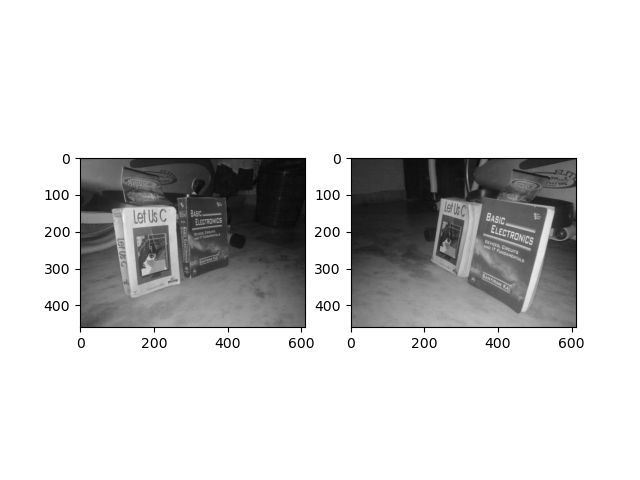

In [3]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(izquierda, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(derecha, cmap='gray', vmin=0, vmax=255)
plt.show()

Para detectar los puntos en común que tienen las imágenes aplicaremos SIFT como detector de puntos clave y descriptores. 
Se utiliza SIFT porque en la práctica anterior (panorámica) se obtuvo los resultados más precisos, aunque fue el que
tardó más tiempo en dar un resultado.

Los puntos en común se calcularán haciendo uso del Matcher de fuerza bruta con k=2.

In [4]:
kp1, desc1 = geometry.get_kp_desc(method="sift", img=izquierda)
kp2, desc2 = geometry.get_kp_desc(method="sift", img=derecha)
matches = geometry.match_descriptors(method="F", desc1=desc1,
                                     desc2=desc2, k=2)

In [5]:
print(len(matches))

815


Para realizar el filtrado de los puntos en común utilizaremos el método KNN con una proporción de 0.95, ya que, con una
proporción menor el sistema se confundía a la hora de generar los resultados. En este caso, al usar SIFT utilizamos
sistemas que trabajen con distancias que no sean binarias.

In [6]:
matches = geometry.filter_matches(method="KNN", matches=matches, proportion=0.95)


In [7]:
print(len(matches))

445


Una vez filtrados obtenemos los puntos para cada una de las imágenes.

In [8]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt
points1 = np.int32(points1)
points2 = np.int32(points2)
print("l1 {} l2 {}".format(points1.shape, points2.shape))

l1 (445, 2) l2 (445, 2)


Una vez obtenidos los puntos podemos proceder a generar la matríz fundamental para poder obtener las líneas epipolares.
Realizamos este proceso ya que no disponemos de la calibración de la cámara y lo realizaremos mediante la
correspondencia entre 2 puntos.

Utilizando este sistema en caso de querer realizar una reconstrucción 3D, sólo tendremos una aproximación.

Para el cálculo de la matriz utilizaremos el algoritmo de RANSAC

In [9]:
F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC)

Al generar la matriz fundamental, aparte de retornarnos la matriz fundamental, nos retorna una máscara que indica qué
puntos son outliers y qué puntos son inliers.
Para que el resultado sea más preciso solamente nos quedaremos con los puntos que son inliers descartando los outliers.

In [10]:
points1 = points1[mask.ravel()==1]
points2 = points2[mask.ravel()==1]
print("l1 {} l2 {}".format(points1.shape, points2.shape))

l1 (151, 2) l2 (151, 2)


Una vez filtrados los puntos, podemos proceder a generar las líneas epipolares y pintarlas.  
Para ello utilizaremos la función de OpenCV ```computeCorrespondEpilines``` que requiere que el vector de puntos
esté en formato $N \times 1$ o en formato $1 \times N$. También requiere indicar a que imagen pertenecen los puntos que
estamos procesando, es decir si los puntos son los de la imagen izquierda o de la derecha, ya que las líneas de la
izquierda pertenecen a los puntos de la derecha con la matriz fundamental y a la inversa y el proceso de cálculo es
diferente para cada imagen.
Para pintar las líneas utilizaremos la función ```draw_epipolar_lines``` del módulo de la asignatura

In [11]:
# convertimos los puntos a Nx1, indicamos que es de la imagen de la derecha y pasamos la matriz fundamental
# para calcular las líneas epipolares de la imagen de la izquierda
lines1 = cv2.computeCorrespondEpilines(points2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3) # Convertimos las líneas para que tengan las 3 componentes ax+by+c = 0
# Finalmente obtenemos las líneas pintadas en la imagen de la izquierda
img5,img6 = geometry.draw_epipolar_lines(izquierda,derecha,lines1,points1,points2) 

In [12]:
# convertimos los puntos a Nx1, indicamos que es de la imagen de la izquierda y pasamos la matriz fundamental
# para calcular las líneas epipolares de la imagen de la derecha
lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3) # Convertimos las líneas para que tengan las 3 componentes ax+by+c = 0
# Finalmente obtenemos las líneas pintadas de la imagen de la derecha.
# Utilizaremos como primera imagen la derecha, después la izquierda y los puntos que corresponden a la imagen de la derecha
img3,img4 = geometry.draw_epipolar_lines(derecha,izquierda,lines2,points2,points1)

<IPython.core.display.Javascript object>


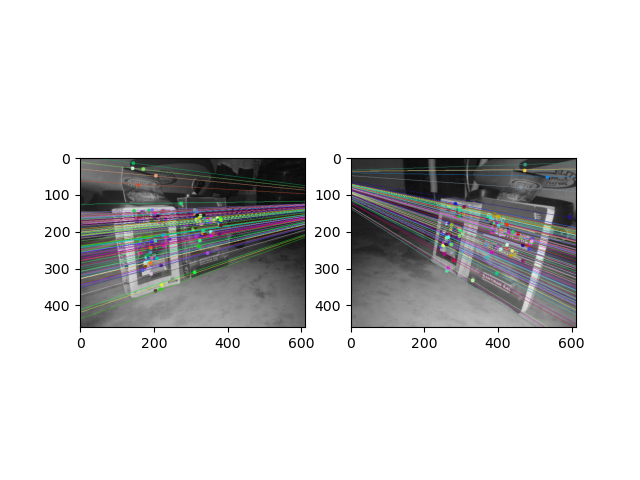

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img5)
plt.subplot(1,2,2)
plt.imshow(img3)
plt.show()

# Imágenes propias
Una vez que tenemos los resultados con la imagen de ejemplo procederemos a realizar el mismo experimento con un
conjunto de imágenes generadas.
Para evitar tener que repetir el código en cada una de las pruebas, definiremos una función que se encargue de realizar
todo el proceso de cálculo y también, agregaremos la función para pintar los matches que detecte para comprobar que la
correspondencia entre las imágenes se realiza de manera correcta.

In [14]:
def generar_imagenes_linieas_epipolares(imagen_izq = None, imagen_der = None, proporcion=0.7, plots = False):
    if plots:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(izquierda_p, cmap='gray', vmin=0, vmax=255)
        plt.subplot(1,2,2)
        plt.imshow(derecha_p, cmap='gray', vmin=0, vmax=255)
        plt.show()

    # Generamos los puntos de referencia y los descriptores
    kp1_p, desc1_p = geometry.get_kp_desc(method="sift", img=imagen_izq)
    kp2_p, desc2_p = geometry.get_kp_desc(method="sift", img=imagen_der)
    
    # Encontramos los matches
    matches_p = geometry.match_descriptors(method="F", desc1=desc1_p,
                                           desc2=desc2_p, k=2)
    
    # Filtramos los matches con la proporción que nos indican
    matches_p = geometry.filter_matches(method="KNN", matches=matches_p, proportion=proporcion)
    
    # Si el usuario lo desea mostramos los matches
    if plots:
        plt.figure()
        res = cv2.drawMatches(imagen_izq, kp1_p, imagen_der, kp2_p,
                                [m[0] for m in matches_p], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(res)
        plt.show()
        
    # Obtenemos los puntos
    points1_p = np.zeros((len(matches_p), 2), dtype=np.float32)
    points2_p = np.zeros((len(matches_p), 2), dtype=np.float32)
    for i, match in enumerate(matches_p):
        points1_p[i, :] = kp1_p[match[0].queryIdx].pt
        points2_p[i, :] = kp2_p[match[0].trainIdx].pt
    points1_p = np.int32(points1_p)
    points2_p = np.int32(points2_p)
    print("l1 {} l2 {}".format(points1_p.shape, points2_p.shape))
    
    # Obtenemos la matriz fundamental
    F_p, mask_p = cv2.findFundamentalMat(points1_p, points2_p)
    
    # Obtenemos los puntos filtrados para que el resultado quede mejor
    points1_p = points1_p[mask_p.ravel()==1]
    points2_p = points2_p[mask_p.ravel()==1]
    print("l1 {} l2 {}".format(points1_p.shape, points2_p.shape))
    
    # convertimos los puntos a Nx1, indicamos que es de la imagen de la derecha y pasamos la matriz fundamental
    # para calcular las líneas epipolares de la imagen de la izquierda
    lines1_p = cv2.computeCorrespondEpilines(points2_p.reshape(-1,1,2), 2,F_p)
    lines1_p = lines1_p.reshape(-1,3) # Convertimos las líneas para que tengan las 3 componentes ax+by+c = 0
    # Finalmente obtenemos las líneas pintadas en la imagen de la izquierda
    img5_p,img6_p = geometry.draw_epipolar_lines(izquierda_p,derecha_p,lines1_p,points1_p,points2_p) 
    
    # convertimos los puntos a Nx1, indicamos que es de la imagen de la izquierda y pasamos la matriz fundamental
    # para calcular las líneas epipolares de la imagen de la derecha
    lines2_p = cv2.computeCorrespondEpilines(points1_p.reshape(-1,1,2), 1,F_p)
    lines2_p = lines2_p.reshape(-1,3) # Convertimos las líneas para que tengan las 3 componentes ax+by+c = 0
    # Finalmente obtenemos las líneas pintadas de la imagen de la derecha.
    # Utilizaremos como primera imagen la derecha, después la izquierda y los puntos que corresponden a la 
    # imagen de la derecha
    img3_p,img4_p = geometry.draw_epipolar_lines(derecha_p,izquierda_p,lines2_p,points2_p,points1_p)
    
    if plots:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img5_p)
        plt.subplot(1,2,2)
        plt.imshow(img3_p)
        plt.show()
    
    return img5_p, img3_p

Una vez que tenemos la función generada podemos utilizarla con nuestras imágenes.  
En este caso hemos hecho 2 paquetes de imágenes.
El primer paquete de imágenes será una réplica de las imágenes que teníamos de base para realizar el proyecto.
En este caso, utilizaremos 2 libros que sean muy diferentes en escala de grises para evitar problemas con SIFT.
Estas imágenes tendrán los libros situados de una manera concreta y después en la otra imagen, se situarán en otra
posición diferente.

El segundo paquete de imágenes será más sencillo. Manteniendo la posición de los libros, desplazaremos la cámara un par
de centímetros a la derecha y generaremos otra imagen.

En una etapa anterior del proyecto, también se generó un tercer pack de imágenes, pero éstas tenían problemas a la hora
de realizar los matches entre imágenes y por este motivo fué descartado.

## Resultados del primer paquete de imágenes

<IPython.core.display.Javascript object>


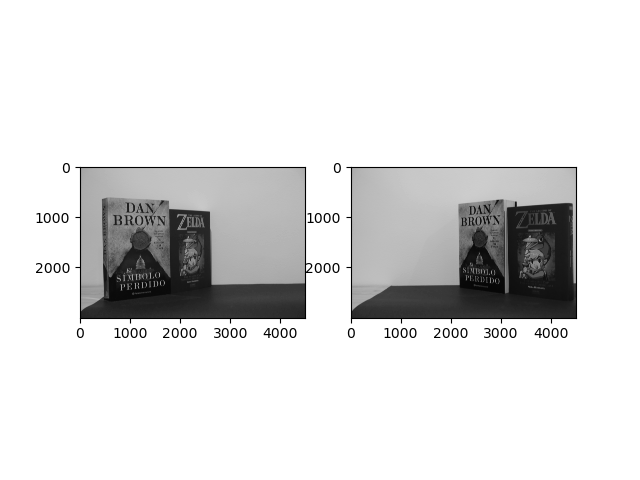

<IPython.core.display.Javascript object>


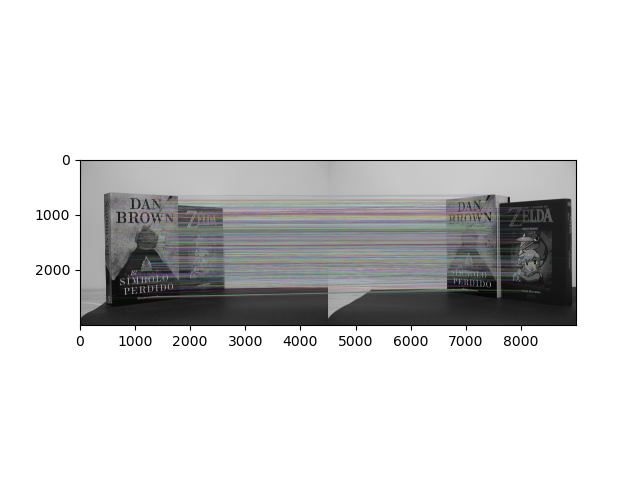

l1 (1658, 2) l2 (1658, 2)
l1 (1398, 2) l2 (1398, 2)


<IPython.core.display.Javascript object>


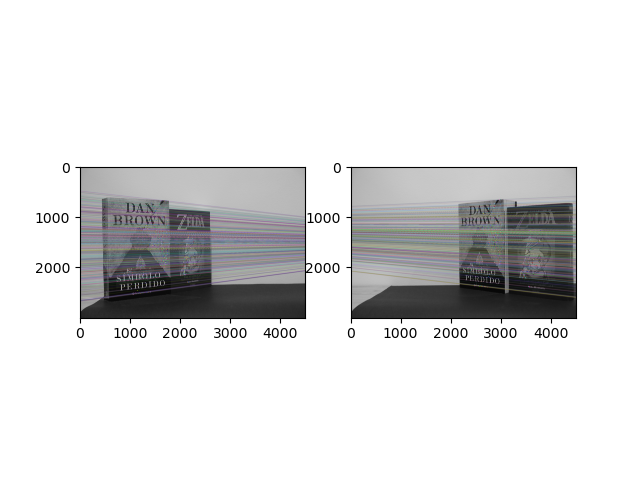

In [15]:
izquierda_p = cv2.imread("../in/epipolar/DSC06567.JPG",  cv2.IMREAD_GRAYSCALE)
derecha_p = cv2.imread("../in/epipolar/DSC06568.JPG", cv2.IMREAD_GRAYSCALE)


imagen_izq_lineas, imagen_der_lineas = generar_imagenes_linieas_epipolares(izquierda_p, derecha_p, 0.7, True )

En este caso vemos que el resultado es muy parecido al que teniamos con las imágenes base, ya que en este caso utilizan
el mismo sistema.

## Resultado del segundo paquete de imágenes

<IPython.core.display.Javascript object>


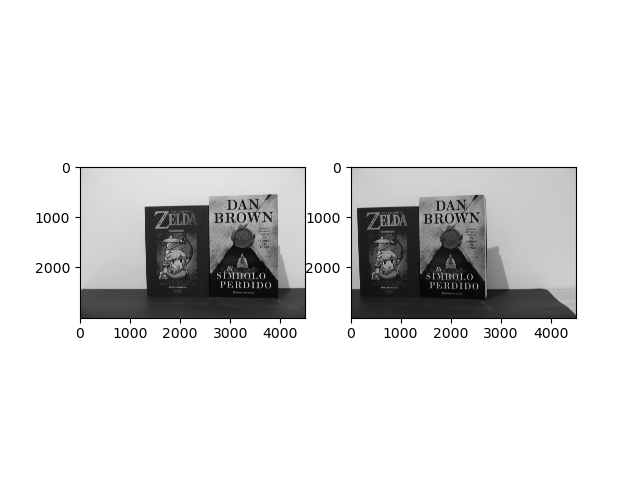

<IPython.core.display.Javascript object>


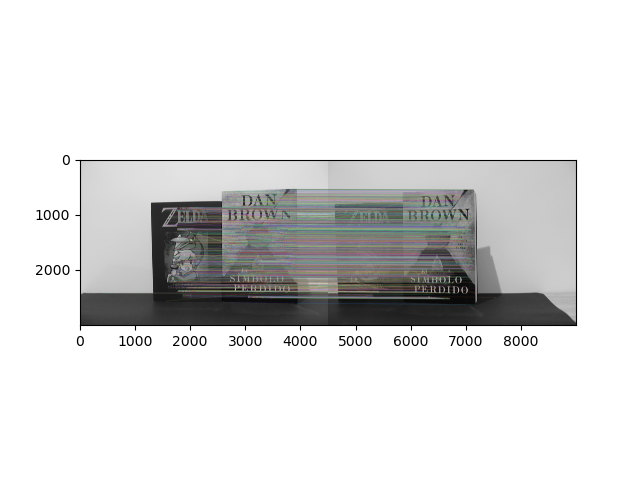

l1 (3790, 2) l2 (3790, 2)
l1 (3326, 2) l2 (3326, 2)


<IPython.core.display.Javascript object>


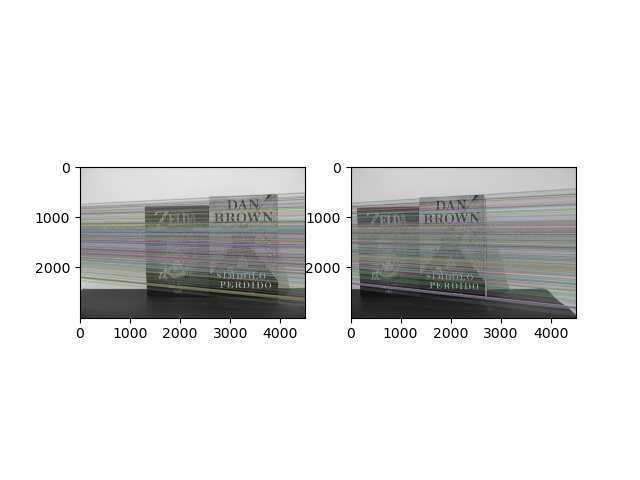

In [16]:
izquierda_p = cv2.imread("../in/epipolar/DSC06562.JPG",  cv2.IMREAD_GRAYSCALE)
derecha_p = cv2.imread("../in/epipolar/DSC06563.JPG", cv2.IMREAD_GRAYSCALE)


imagen_izq_lineas, imagen_der_lineas = generar_imagenes_linieas_epipolares(izquierda_p, derecha_p, 0.7, True )

En este caso las líneas van en la misma dirección porque la distancia entre las imágenes es pequeña y la diferencia de
ángulo entre una y otra es pequeña.